In [1]:
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.distributions import MultivariateNormal, Normal
from torchvision.transforms import ToTensor
from torchvision.models import resnet18
import torch.nn.functional as F

from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import *
from get_data import *
from model import *

In [2]:
%load_ext autoreload
%autoreload 2

torch.cuda.empty_cache()

In [3]:
# from check_cuda_mem import dump_tensors
# dump_tensors()

Total size: 0


# Get data

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATAPATH = 'C:/Users/matan/Documents/data/coil-20-proc'
root_dir = DATAPATH + '/coil-20-proc'
csv_file = 'C:/Users/matan/Documents/data/coil-20-proc/labels.csv'
df = pd.read_csv(csv_file)

Number of images in the dataset:  1440
Image shape: torch.Size([1, 128, 128])


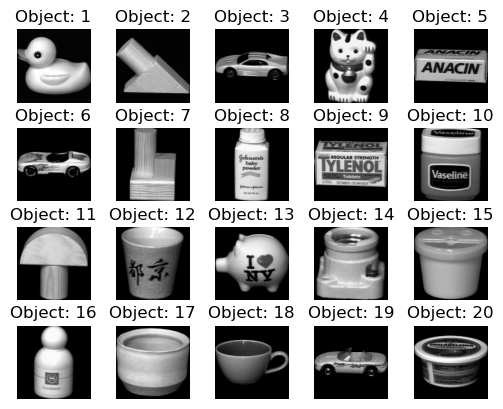

tensor(1.)
tensor([0.4471, 0.4471, 0.4431, 0.4431, 0.4275, 0.4235, 0.4157, 0.4078, 0.3922,
        0.4000, 0.4510, 0.5569, 0.6314, 0.5961, 0.5529, 0.5725, 0.5608, 0.4941,
        0.4353, 0.3490, 0.2706, 0.2588, 0.2549, 0.2784, 0.3451, 0.3412, 0.4078,
        0.4510, 0.3843, 0.3647])


In [5]:
dataset = COIL20(root_dir, csv_file, transform=ToTensor())
print("Number of images in the dataset: ", len(dataset))
img, label = dataset[0]
input_size = img.shape
print("Image shape:", img.shape)

indices = {}
i = 0
while len(indices) < 20:
    _, label = dataset[i]
    if label not in indices.keys():
        indices[label] = i
    i += 1
    
fig = plt.figure()
gs = fig.add_gridspec(4,5, hspace=0.35, wspace=0)
axs = gs.subplots()
for l in range(20):
    img, label = dataset[indices[l+1]]
    assert label == l + 1
    r, c = (l)//5, l%5
    axs[r,c].imshow(img.permute(1,2,0), cmap=plt.get_cmap('gray'))
    axs[r,c].set_title("Object: " + str(label))
    axs[r,c].axis('off')
plt.show()

print(torch.max(dataset[20][0]))        # Max pixel value
print(dataset[20][0][0][100][50:80])    # Print some pixel values

In [6]:
# Divide into train, test, and val
N = len(dataset)
test_size = int(0.1*N)
val_size = int(0.1*N)
train_size = N - test_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
print("Training images: ", len(train_data))
print("Validation images: ", len(val_data))
print("Test images: ", len(test_data))

batch_size = 64
#kwargs = {'num_workers': 1, 'pin_memory': True} 
kwargs = {}
train_loader = DataLoader(train_data, batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_data, len(test_data), shuffle=True, **kwargs)
val_loader = DataLoader(val_data, len(val_data), **kwargs)

# For access to the whole training set during evaluation
training_set = DataLoader(train_data, len(train_data), shuffle=False, **kwargs)

Training images:  1152
Validation images:  144
Test images:  144


# Create the model

### Create loss function

In [7]:
def loss_function(x, out, mean, log_var, N = 1152, beta = 1):
    """ Loss function for the model. """
    M = x.shape[0]      # Batch size

    x_hat=out
    reproduction_loss = ((x - x_hat)**2).sum(dim=(1,2,3))
    KL_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1)
    KL_divergence = KL_divergence * beta

    # SUM FOR BATCH LIKE IN KINGMA
    reproduction_loss = torch.sum(reproduction_loss, dim=0)
    KL_divergence = torch.sum(KL_divergence, dim=0)
    loss = (N/M) * KL_divergence + reproduction_loss

    return reproduction_loss + KL_divergence, reproduction_loss, KL_divergence

### Create VAE model

In [8]:
# Hyperparameters
lr = 0.008
in_channels = 1
input_size = [in_channels, 128, 128]
latent_dim = 16 #32 #512
n_classes = 20
seed = 11       # Random seed for reproducible results
torch.manual_seed(seed);
RESULTS_PATH = './model_COIL20_resnet18'

model = VAE(z_dim=latent_dim, img_size=input_size).to(DEVICE)
print(model)

VAE(
  (encoder): ResNet18Enc(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

### Does it run? Try to push a batch though the model

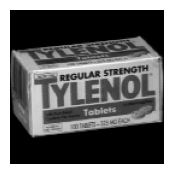

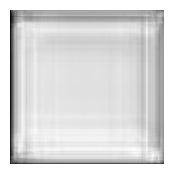

In [9]:
model.eval()
examples = enumerate(test_loader)
with torch.no_grad():
    batch, (x, labels) = next(examples)
    #x = x.view(x.size(0), dim_input)
    x = x.to(DEVICE)
    x_hat, mean, logvar = model(x)

def show_image_in_batch(images, idx):
    input_size = images.shape[1:]
    images = images.view(images.shape[0], input_size[-2], input_size[-1])
    fig = plt.figure(figsize=(2,2))
    plt.imshow(images[idx].cpu().numpy(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

show_image_in_batch(x, idx=0)
show_image_in_batch(x_hat, idx=0)
loss, r_loss, kl = loss_function(x, x_hat, mean, logvar, beta=1)

# Train the model

In [10]:
optimizer = Adam(model.parameters(), lr=lr)
print(DEVICE)

cuda


In [11]:
# Train the model
epochs = 100
validation_loss = []
train_losses = []
train_r_losses = []
train_kl_losses = []
beta_vals = []
step = 0
for epoch in range(epochs):
    model.train()
    loss_this_epoch = 0
    r_loss_this_epoch = 0
    kl_loss_this_epoch = 0
    for batch, (x, label) in enumerate(train_loader):
        batch_size = x.shape[0]
        x = x.to(DEVICE)

        assert not torch.isnan(x).any()
        optimizer.zero_grad()

        out, mean, logvar = model(x)
        x_hat = out

        if torch.isnan(x_hat.view(-1)).sum().item() != 0:
            print("Number of nans:", torch.isnan(x_hat.view(-1)).sum().item())
            print(x_hat)
        assert not torch.isnan(x_hat).any()
        
        #loss = loss_function(x, out, q_mean, q_log_var)
        beta = 1#beta_func(step)
        loss, r_loss, kl = loss_function(x, x_hat, mean, logvar, beta=beta)
        loss_this_epoch += loss.item() 
        r_loss_this_epoch += r_loss.item()
        kl_loss_this_epoch += kl.item()
        beta_vals.append(beta)
        step += 1

        loss.backward()
        optimizer.step()

    train_losses.append(loss_this_epoch / ((batch+1)*batch_size))
    train_r_losses.append(r_loss_this_epoch / ((batch+1)*batch_size))
    train_kl_losses.append(kl_loss_this_epoch / ((batch+1)*batch_size))
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", loss_this_epoch / ((batch+1)*batch_size))
    print("\t\t\t\tReproduction loss:", r_loss_this_epoch / ((batch+1)*batch_size) ,"\tKL-div:", kl_loss_this_epoch / ((batch+1)*batch_size))

    model.eval()
    with torch.no_grad():
        for batch, (x, label) in enumerate(val_loader):
            batch_size = x.shape[0]
            x = x.to(DEVICE)
            x_hat, q_mean, q_log_var = model(x)
            loss, r_loss, kl = loss_function(x, x_hat, mean, logvar, beta=1)
            validation_loss.append(loss.item() / len(val_data))

	Epoch 1 complete! 	Average Loss:  1883229.5583699543
				Reproduction loss: 1842.222459581163 	KL-div: 1881387.352465166
	Epoch 2 complete! 	Average Loss:  1187.922410753038
				Reproduction loss: 1096.5498860677083 	KL-div: 91.37252468532986
	Epoch 3 complete! 	Average Loss:  1030.868431939019
				Reproduction loss: 958.8374192979601 	KL-div: 72.03101603190105
	Epoch 4 complete! 	Average Loss:  944.9818216959635
				Reproduction loss: 878.2247585720486 	KL-div: 66.75706884596083
	Epoch 5 complete! 	Average Loss:  854.16259765625
				Reproduction loss: 798.7205064561632 	KL-div: 55.44209501478407
	Epoch 6 complete! 	Average Loss:  791.6806233723959
				Reproduction loss: 742.3583238389757 	KL-div: 49.32229804992676
	Epoch 7 complete! 	Average Loss:  746.1910502115885
				Reproduction loss: 699.1189371744791 	KL-div: 47.07211282518175
	Epoch 8 complete! 	Average Loss:  725.1486443413628
				Reproduction loss: 678.3092380099827 	KL-div: 46.83940654330783
	Epoch 9 complete! 	Average Loss

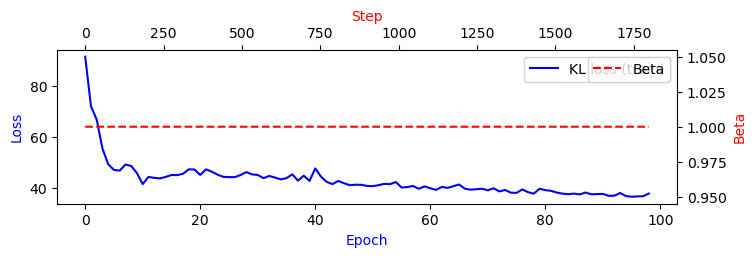

In [12]:
fig = plt.figure(figsize=(8,2))
ax1 = fig.add_subplot(111, label='1')
ax2 = fig.add_subplot(111, label='2', frame_on=False)

ax1.plot(range(epochs-1), train_kl_losses[1:], color='blue', label = "KL loss (train)")
ax1.set_xlabel("Epoch", color='blue')
ax1.set_ylabel("Loss", color='blue')
ax1.legend()

ax2.plot(range(step-1), beta_vals[1:], color='red', linestyle='dashed', label = "Beta")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel("Step", color='red')
ax2.set_ylabel("Beta", color='red')
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
ax2.legend()
plt.show()

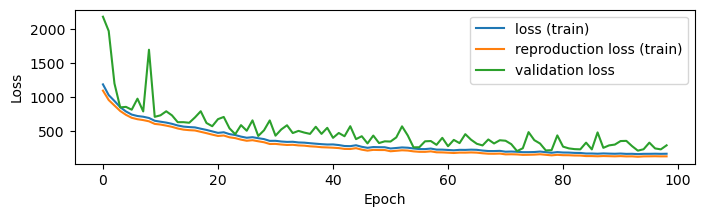

In [13]:
plt.figure(figsize=(8,2))
plt.plot(range(epochs-1), train_losses[1:], label = "loss (train)")
plt.plot(range(epochs-1), train_r_losses[1:], label = "reproduction loss (train)")
plt.plot(range(epochs-1), validation_loss[1:], label = 'validation loss')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

# Evaluate the model

### Recontruct some images

<Figure size 400x200 with 0 Axes>

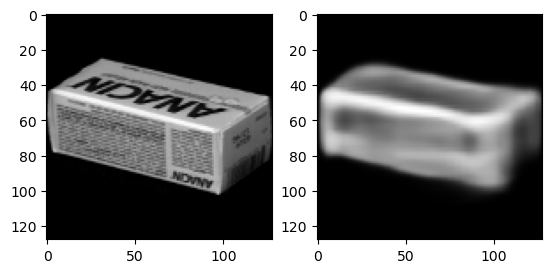

In [14]:
model.eval()

# See reconstruction of an image in the training set
img, label = train_data[900]
img_repro, _, _ = model(img.unsqueeze(0).to(DEVICE))
img_repro = img_repro.reshape(input_size).cpu().detach()
plt.figure(figsize=(4,2))
fig, axs = plt.subplots(1,2)
axs[0].imshow(img.permute(1,2,0), cmap=plt.get_cmap('gray'))
axs[1].imshow(img_repro.permute(1,2,0), cmap=plt.get_cmap('gray'))
plt.show()

<Figure size 400x200 with 0 Axes>

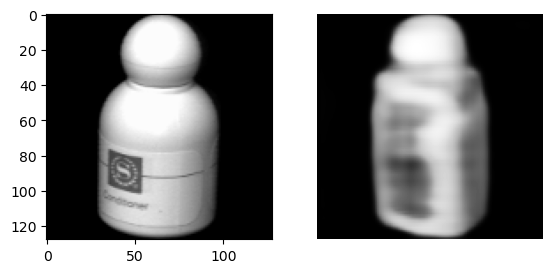

In [35]:
model.eval()

# See reconstruction of an image in the test set
examples = enumerate(test_loader)
with torch.no_grad():
    batch, (x, labels) = next(examples)
    x = x.to(DEVICE)
    x_hat, _, _ = model(x)

def show_image_in_batch(images, reconstructed_images, idx):
    images = images.view(images.shape[0], input_size[-2], input_size[-1])
    reconstructed_images = reconstructed_images.view(reconstructed_images.shape[0], input_size[-2], input_size[-1])
    #fig = plt.figure(figsize=(2,2))
    plt.figure(figsize=(4,2))
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(images[idx].cpu().numpy(), cmap=plt.get_cmap('gray'))
    axs[1].imshow(reconstructed_images[idx].cpu().numpy(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

show_image_in_batch(x, x_hat, idx=0)

### Plot the latent space

c:\Users\matan\miniconda3\envs\vae-project\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\matan\miniconda3\envs\vae-project\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1152 samples in 0.000s...
[t-SNE] Computed neighbors for 1152 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1152
[t-SNE] Computed conditional probabilities for sample 1152 / 1152
[t-SNE] Mean sigma: 1.473501
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.017532
[t-SNE] KL divergence after 1000 iterations: 0.816868


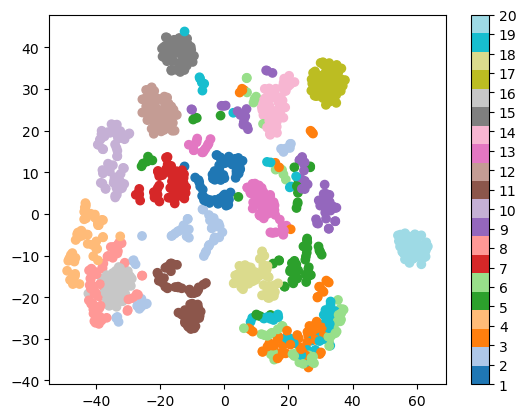

In [29]:
# Make T-SNE plot of latent space
plot_latent_space_tsne(model, training_set)

c:\Users\matan\miniconda3\envs\vae-project\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\matan\miniconda3\envs\vae-project\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1152 samples in 0.016s...
[t-SNE] Computed neighbors for 1152 samples in 1.149s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1152
[t-SNE] Computed conditional probabilities for sample 1152 / 1152
[t-SNE] Mean sigma: 9.950441
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.969353
[t-SNE] KL divergence after 1000 iterations: 0.367295


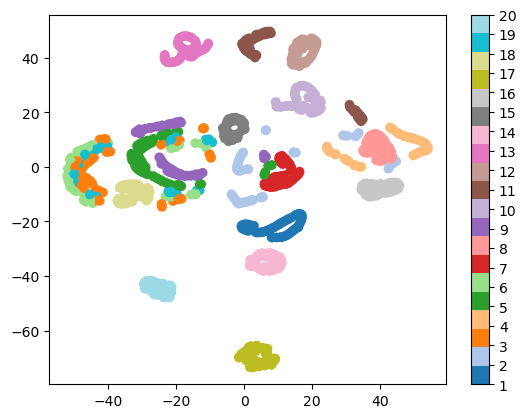

In [17]:
plot_data_space_tsne(training_set)

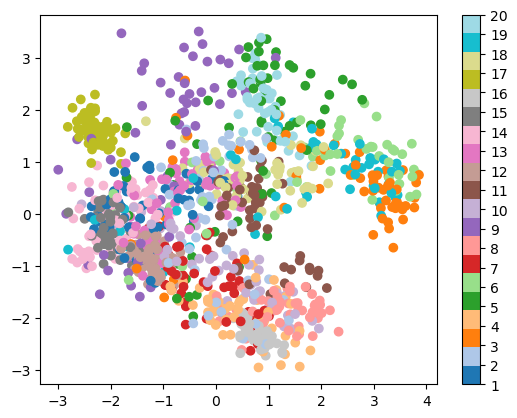

In [30]:
plot_latent_space_pca(model, training_set)

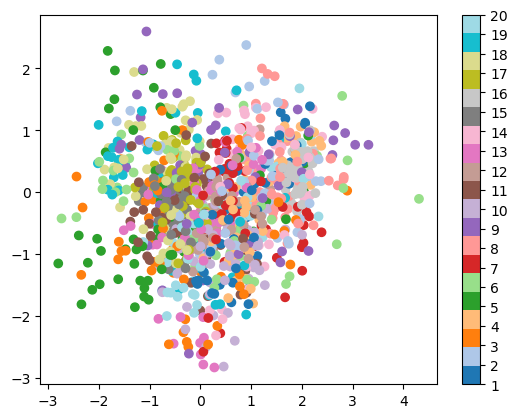

In [32]:
plot_latent_space2d(model, training_set, dims=[0,1])

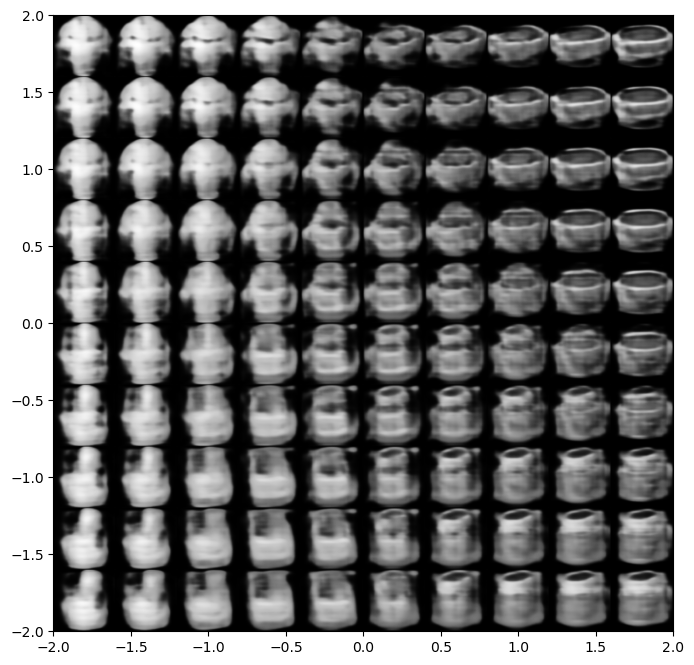

In [36]:
plot_reconstructed(model, ax0=(-2,2), ax1=(-2,2), dims=[2,4], n=10, img_size=input_size[-2:])

### Evaluate the clusters

In [21]:
data_sil_score = silhouette_score_in_data(training_set, n_batches=1)
print("Silhouette score of clusters in data space:", data_sil_score)
latent_sil_score = silhouette_score_in_latents(training_set, model, n_batches=1)
print("Silhouette score of clusters in latent space:", latent_sil_score)

Silhouette score of clusters in data space: 0.15568706
Silhouette score of clusters in latent space: 0.08782666


### Other stuff

Computing t-SNE embedding...


c:\Users\matan\miniconda3\envs\vae-project\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\matan\miniconda3\envs\vae-project\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Plotting t-SNE visualization...


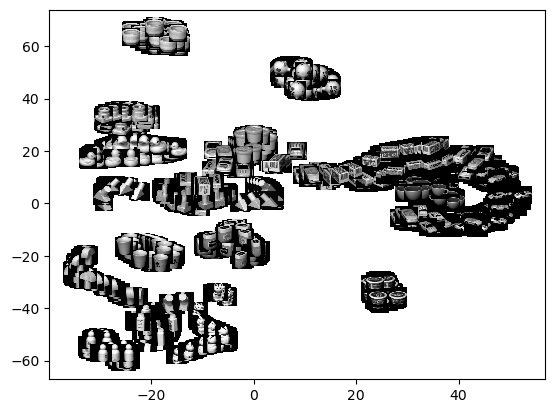

In [22]:
computeTSNEProjectionOfPixelSpace(training_set, display=True)

Computing latent space projection...
Computing t-SNE embedding...


c:\Users\matan\miniconda3\envs\vae-project\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\matan\miniconda3\envs\vae-project\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Plotting t-SNE visualization...


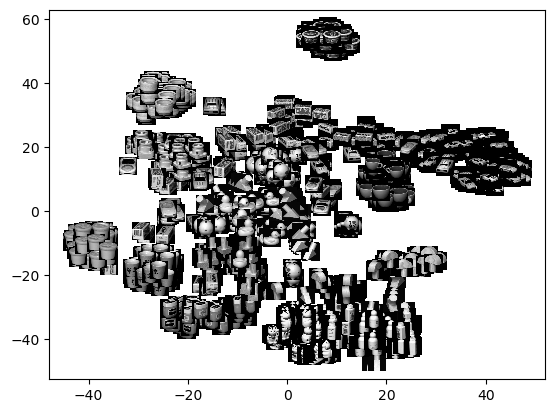

In [23]:
computeTSNEProjectionOfLatentSpace(training_set, model, display=True)

# Save and/or load trained model and results

In [24]:
RESULTS_PATH = os.path.join('C:\\Users\\matan\\OneDrive - Universitetet i Oslo\\Documents\\Projects\\vae-project', 'results\\models')

In [37]:
print(RESULTS_PATH)
torch.save(model, os.path.join(RESULTS_PATH, 'VAE_COIL20_resnet'))

C:\Users\matan\OneDrive - Universitetet i Oslo\Documents\Projects\vae-project\results\models


In [26]:
# Load
#model= torch.load(os.path.join(RESULTS_PATH, 'VAE_COIL20_resnet'))